[ 700.7166737   535.20501054 1084.68865635  881.64       1204.73723541
 1074.11392656  943.4906177   812.86730885  682.244       637.9724
  593.7008      549.4292      505.1576      460.886       416.6144
  372.3428      328.0712      283.7996      239.528       226.9196
  214.3112      201.7028      189.0944      176.486       163.8776
  151.2692      138.6608      126.0524      113.444       108.45199
  103.45998      98.46797      93.47596      88.48395      83.49194
   78.49993      73.50792      68.51591      63.5239       61.1381
   58.7523       56.3665       53.9807       51.5949       49.2091
   46.8233       44.4375       42.0517       39.6659       38.63811
   37.61032      36.58253      35.55474      34.52695      33.49916
   32.47137      31.44358      30.41579      29.388        28.36021
   27.33242      26.30463      25.27684      24.24905      23.22126
   22.19347      21.16568      20.13789      19.1101       18.60774507
   18.10539015   17.60303522   17.1006803    16.

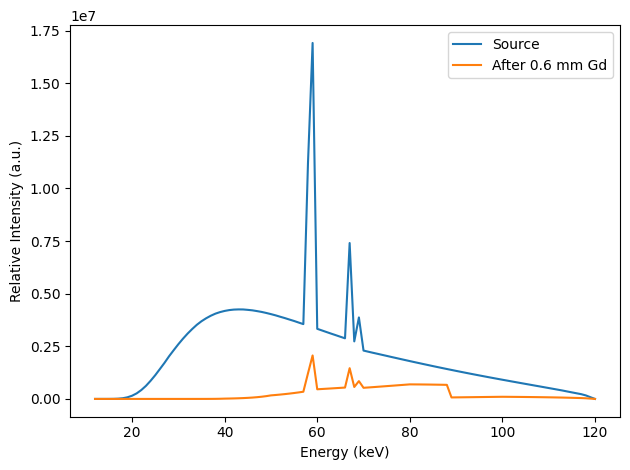

In [1]:
import math, numpy as np

# ---------- 1) 读文件工具（自动跳过非数字行） ----------
def load_two_cols(path):
    E, Y = [], []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for ln in f:
            s = ln.strip().split()
            if len(s) < 2: 
                continue
            try:
                e = float(s[0]); y = float(s[1])
            except ValueError:
                continue
            E.append(e); Y.append(y)
    E = np.asarray(E, float); Y = np.asarray(Y, float)
    idx = np.argsort(E)
    return E[idx], Y[idx]

# ---------- 2) 输入路径 ----------
# SpekCalc 导出的原始谱 (两列：Energy[keV], Intensity)
spek_path = "spek_120.txt"
# XCOM Gd 的 (mu/rho) CSV/TXT (两列：Energy[keV], mu_over_rho[cm^2/g])
xcom_gd_path = "Pb_mu_over_rho.csv"

# ---------- 3) 读取数据 ----------
E_keV, Phi_in = load_two_cols(spek_path)
Ex_MeV, mu_over_rho = load_two_cols(xcom_gd_path)  # Gd
 
# ---- 就地把 XCOM 能量统一到 keV（若是 MeV 就 ×1000） ----
# if Ex_MeV.max() < 10 and E_keV.max() > 10:
Ex_keV = Ex_MeV * 1000.0   # MeV -> keV

# ---------- 4) 参数：Gd 密度与厚度 ----------
rho_gd = 7.90       # g/cm^3（Gd 密度）
thickness_mm = 0.5  # 滤波片厚度（mm）
x_cm = thickness_mm * 0.1  # mm -> cm

# ---------- 5) 按教材 N = N0 * exp(-(mu/rho)*rho*x) 计算 ----------
# 先把 (mu/rho)(E) 插值到 Spek 的能量点
mu_rho_interp = np.interp(E_keV, Ex_keV, mu_over_rho, left=mu_over_rho[0], right=mu_over_rho[-1])
mu_cm_inv = mu_rho_interp * rho_gd          # 线性衰减系数 mu(E) [cm^-1]
print(mu_cm_inv)

T = np.exp(-mu_cm_inv * x_cm)               # 透过率
Phi_out = Phi_in * T                        # 衰减后的谱

# ---------- 6) 保存结果 ----------
np.savetxt("spectrum_filtered_Pb_0_5mm.txt", np.column_stack([E_keV, Phi_out]),
           header="Energy_keV  Phi_filtered", fmt="%.6f")

# ---------- (可选) 画图 ----------
try:
    import matplotlib.pyplot as plt
    plt.plot(E_keV, Phi_in,  label="Source")
    plt.plot(E_keV, Phi_out, label="After 0.6 mm Gd")
    plt.xlabel("Energy (keV)"); plt.ylabel("Relative Intensity (a.u.)")
    plt.legend(); plt.tight_layout(); plt.show()
except Exception:
    pass



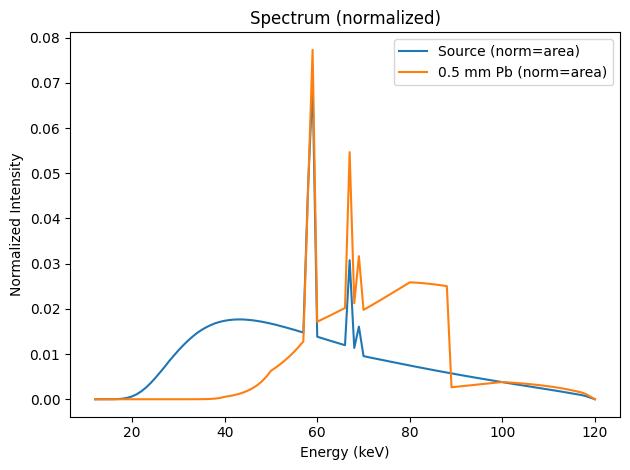

In [4]:
# ---------- (可选) 画图（归一化对比：area 或 peak） ----------
try:
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.integrate import trapezoid

    norm_mode = "area"   # 可选: "area" 或 "peak"

    def normalize(E, Y, mode="area"):
        Y = np.asarray(Y, float)
    
        # 兼容 NumPy 1.x / 2.x：优先用 trapezoid，若不存在则回退 trapz
        trap = getattr(np, "trapezoid", np.trapz)
    
        if mode == "area":
            area = trapezoid(np.maximum(Y, 0), E)
            return Y / area if area > 0 else Y
        elif mode == "peak":
            m = np.max(Y) if Y.size else 0.0
            return Y / m if m > 0 else Y
        else:
            return Y

    Phi_in_n  = normalize(E_keV, Phi_in,  norm_mode)
    Phi_out_n = normalize(E_keV, Phi_out, norm_mode)

    plt.plot(E_keV, Phi_in_n,  label=f"Source (norm={norm_mode})")
    plt.plot(E_keV, Phi_out_n, label=f"0.5 mm Pb (norm={norm_mode})")
    plt.xlabel("Energy (keV)")
    plt.ylabel("Normalized Intensity")
    plt.title("Spectrum (normalized)")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception:
    pass

[SOURCE] len=109, finite(E)=109, finite(Y)=109, min(Y)=0.0, max(Y)=16909870.0


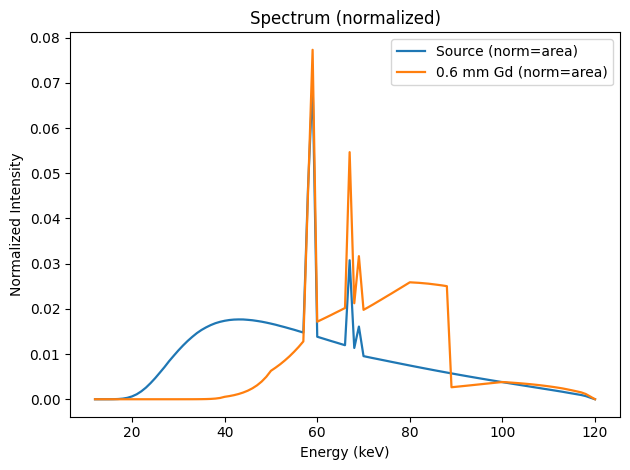

In [3]:
# ---- 计算前先做一次快速体检 ----
def check_array(name, x, y):
    print(f"[{name}] len={len(x)}, finite(E)={np.isfinite(x).sum()}, finite(Y)={np.isfinite(y).sum()}, "
          f"min(Y)={np.nanmin(y) if y.size else 'NA'}, max(Y)={np.nanmax(y) if y.size else 'NA'}")

check_array("SOURCE", E_keV, Phi_in)

# 若有 NaN/Inf，清洗一下
finite_mask = np.isfinite(E_keV) & np.isfinite(Phi_in)
E_keV = E_keV[finite_mask]
Phi_in = Phi_in[finite_mask]

# 万一只有一个点或为空，直接退出以免后面 silently fail
if E_keV.size < 2:
    raise ValueError("源谱点数少于 2，无法绘制。请检查 spek_120.txt 的路径与内容。")

# ---- 归一化函数（处理 NaN/Inf/全零），兼容 numpy 2.0 ----
def normalize(E, Y, mode="area"):
    Y = np.asarray(Y, float)
    E = np.asarray(E, float)

    # 清洗：把非有限值替换为 0，防止 area 变 NaN
    Y = np.nan_to_num(Y, nan=0.0, posinf=0.0, neginf=0.0)

    # trapz→trapezoid 兼容
    trap = getattr(np, "trapezoid", np.trapz)

    if mode == "area":
        area = trap(np.maximum(Y, 0.0), E)
        if not np.isfinite(area) or area <= 0:
            # 面积不可用时，退化为峰值归一或直接返回原曲线
            m = np.max(Y) if Y.size else 0.0
            return (Y / m) if m > 0 else Y
        return Y / area
    elif mode == "peak":
        m = np.max(Y) if Y.size else 0.0
        return (Y / m) if m > 0 else Y
    else:
        return Y

# ---- 画图（显式抛错，别吞异常）----
import matplotlib.pyplot as plt

norm_mode = "area"   # "area" or "peak"
Phi_in_n  = normalize(E_keV, Phi_in,  norm_mode)
Phi_out_n = normalize(E_keV, Phi_out, norm_mode)

plt.plot(E_keV, Phi_in_n,  label=f"Source (norm={norm_mode})", linewidth=1.6)
plt.plot(E_keV, Phi_out_n, label=f"0.6 mm Gd (norm={norm_mode})", linewidth=1.6)
plt.xlabel("Energy (keV)")
plt.ylabel("Normalized Intensity")
plt.title("Spectrum (normalized)")
plt.legend()
plt.tight_layout()
plt.show()
